**извлечение признаков из текста на естественном языке**

word2vec : skip-gram


Евгений Борисов <esborisov@sevsu.ru>

---

In [1]:
import re
import gzip
import numpy as np
from numpy import random as rng

## загружаем текст 

In [2]:
# import urllib

# url='http://lib.ru/NEWPROZA/LOBAS/taxisty.txt'
# text = urllib.open(url).read()
# print(text)

In [3]:
import requests
from bs4 import BeautifulSoup

url='http://lib.ru/NEWPROZA/LOBAS/taxisty.txt'
text = BeautifulSoup(requests.get(url).text).get_text()
with open('taxisty.txt','wt') as f: f.write(text)
text = text[322:-7261] # выкидываем заголовок и хвост страницы 
print(text[:362])




           ЖЕЛТЫЕ КОРОЛИ 
     Записки нью-йоркского таксиста


     Товарищам моим -- белым и черным, американцам и эмигрантам  из России и
Израиля,  из  Греции  и  Кореи,  арабам,  китайцам,  полякам  и всем  прочим
таксистам города  Нью-Йорк  в знак глубокого  уважения к  их нечеловеческому
труду эту горькую книгу посвящаю...

     Водитель No 320718
   


In [4]:
# with gzip.open('../data/text/lobas-taxisty.txt.gz','rt') as f: 
#     text = f.read()[654:]  # ...и выкидываем заголовок
# print('символов:%i\n'%(len(text)))
# print(text[:327].strip())

## выполняем токенизацию

In [5]:
from nltk import __version__ as nltk_version
print('nltk version:',nltk_version)

nltk version: 3.8.1


In [6]:
from random import sample
from nltk.tokenize import sent_tokenize as nltk_sentence_split
from nltk.tokenize import word_tokenize as nltk_tokenize_word
from nltk.corpus import stopwords as nltk_stopwords

stopwords = set() # set(nltk_stopwords.words('russian')) 

text = [ 
    [ 
     t.lower() 
     for t in nltk_tokenize_word(s) 
     if re.match(r'[а-я -]+',t.lower()) and len(t)>1 
#      if not( (t.lower() in stopwords) or (len(t)<3) ) 
    ] # разбиваем предложения на слова
    for s in nltk_sentence_split(text) # режем текст на отдельные предложения
]

print('предложений: %i\n'%(len(text)))

sample(text,5)

предложений: 6686



[['по',
  'правилам',
  'дверцы',
  'пассажирского',
  'салона',
  'всегда',
  'должны',
  'быть',
  'открыты',
  'но',
  'кэбби-аристократ',
  'придерживался',
  'противоположного',
  'мнения',
  'по',
  'этому',
  'поводу',
  '--',
  'все',
  'четыре',
  'дверцы',
  'твоего',
  'кэба',
  'должны',
  'быть',
  'постоянно',
  'закрыты',
  'на',
  'замки'],
 ['позвать', 'полицию'],
 ['так',
  'значит',
  'нужно',
  'запустить',
  'еще',
  'три',
  'тачки',
  'засадить',
  'еще',
  'девять',
  'водил',
  'пусть',
  'работают'],
 ['такая',
  'же',
  'рука',
  'только',
  'из',
  'синих',
  'не',
  'из',
  'красных',
  'трубок',
  'мерцала',
  'окне',
  'дома',
  'которого',
  'мы',
  'оста-новились'],
 ['--',
  'началась',
  'заново',
  'южном',
  'бронксе',
  'конторе',
  'майкла',
  'росса',
  'встретился',
  'моим',
  'будущим',
  'партнером',
  'стивом',
  'таксистом',
  'который',
  'десять',
  'лет',
  'оттрубил',
  'за',
  'баранкой',
  'гаражного',
  'кэба',
  'собирая',
  'восемн

In [7]:
# заменяем слова в тексте их номерами в словаре
words = sorted(set(sum(text,[]))) # словарь из текста
vocab =  { w:i for i,w in enumerate(words) }

In [8]:
del words

In [9]:
n_words = len(vocab) # количество слов в словаре
print( "размер словаря: %i слов" % n_words )

размер словаря: 22062 слов


## собираем контексты

In [10]:
# from nltk.util import bigrams
from nltk.util import ngrams as nltk_ngrams

# вынимаем все n-gram из текста
ngram_len = 5

text_ngrams = [ 
    ngram 
    for s in text if len(s)>ngram_len
    for ngram in nltk_ngrams(s,ngram_len) 
]
print('количество n-gram: %i'%(len(set(text_ngrams))))
sample(text_ngrams,5)

количество n-gram: 57205


[('--', 'вы', 'подумайте', 'меня', 'ведут'),
 ('толкотней', 'повалили', 'внутрь', '--', 'эй'),
 ('унижать', 'пожилого', 'человека', 'полуизвиняясь', 'заключенный'),
 ('вторую', 'часть', '--', 'хозяева', 'сколько'),
 ('сейчас', 'этот', 'колизей', 'плакала', 'моя')]

In [11]:
text_ngrams = sample(text_ngrams,1_000) # сокращаем учебный набор для ускорения процесса

### кодируем слова

In [12]:
T = np.array([ [ vocab[w] for w in ngrams ] for ngrams in text_ngrams ]) # кодируем слова

wn = ngram_len//2

W = T[:,wn] # коды слов
C = np.delete(T,wn,axis=1) # коды слов контекста

assert len(C) == len(W)

C.shape, W.shape

((1000, 4), (1000,))

In [13]:
del text_ngrams
del text
del T

In [14]:
# # унитарное кодирование слов (one-hot-encoding)
E = np.eye(n_words,dtype=np.int8)

Wbin = np.vstack([ E[c] for c in W ])
Cbin = np.vstack([ np.vstack([ E[c] for c in Ci ])[np.newaxis,:] for Ci in C ]) 

Cbin.shape, Wbin.shape

((1000, 4, 22062), (1000, 22062))

In [15]:
del W
del C

## строим модель Skip-Gram

In [16]:
# будем по контексту предсказывать слово

In [17]:
# ф-ция активации скрытого слоя - линейная
# def act(s): return s

# ф-ция активации выходного слоя
def softmax(s): 
    e = np.exp(s)
    return e/e.sum(axis=1).reshape(s.shape[0],1)

In [18]:
def w2v_step(W,Vi,Vo):
    H = W.dot(Vi) # значения скрытого слоя
    U = H.dot(Vo) # состояния выходного слоя
    O = softmax(U) # выход сети
    return H,U,O


Функция потери

$$E = \left| \sum\limits_i\log\left( \sum\limits_k \exp(U_{ik}) \right) - \sum\limits_i\sum\limits_k\sum\limits_j (U_{ik} * Q_{ijk}) \right| $$


$U_{ik}$ состояние k-того нейрона выходного слоя для слова $i$     
$Q_{ij}$ слово $j$ контекста слова $i$   
где ∗ - операция поэлементного умножения векторов

In [19]:
def w2v_loss(U,C):
    n,cws,v = C.shape 
    # количество примеров
    # размер окна контекста   
    # количество слов в словаре

    Us = np.log( np.exp(U).sum(axis=1) ).sum()

    Uo = 0.0
    for i in range(cws): # для всех слов контекста
        Ci = C[:,i,:].reshape([n,v]) # набор слов контекста i
        Uo += (U*Ci).sum() # значения выходного слоя для слов x контекста i

    return np.abs(Us-Uo)/n

In [20]:
def w2v_grad(C,W,H,O,Vo):
    n,cws,v = C.shape
        # количество примеров
        # размер окна контекста   
        # количество слов в словаре

    gVi = gVo = 0.0 

    for i in range(cws):
        Ci = C[:,i,:].reshape([n,v]) # слово i контекста
        D = O - Ci # ошибка на слове контекста i
        gVo += D.T.dot(H).T
        gVi += W.T.dot(D).dot(Vo.T)

    return gVi,gVo

In [21]:
def w2v_weigth_norm(v,w):
    nn = np.linalg.norm( np.hstack([ v.flatten(), w.flatten() ]) )
    #nn = np.abs( np.hstack([ v.flatten(), w.flatten() ]) ).max()
    return (v/nn,w/nn) if nn!=0.0 else (v,w)

### обучаем модель

In [22]:
n = Wbin.shape[1] # количество слов в словаре
k = 30 # размер скрытого слоя H

Vi = rng.normal(scale=.01,size=(n,k))
Vo = rng.normal(scale=.01,size=(k,n))

In [23]:
from tqdm.auto import tqdm

In [24]:
%%time

a = .91 # скорость обучения

er = [1e10]

n_steps = 50

for i in tqdm(range(n_steps)):
    H,U,O = w2v_step(Wbin,Vi,Vo) # вычисляем состояния слоёв и выход
    er.append(w2v_loss(U,Cbin)) # вычисляем ошибку
    #print(i+1, er[-1])
    if er[-1]>er[-2]: 
        Vi, Vo = Vi_old, Vo_old
        break
        
    gVi, gVo = w2v_grad(Cbin,Wbin,H,O,Vo) # вычисляем градиент ф-ции потери
    gVi,gVo = w2v_weigth_norm(gVi,gVo) # нормируем значения градиента
    
    Vi_old, Vo_old =  Vi, Vo # сохраняем старые веса
    
    Vi,Vo = Vi-a*gVi, Vo-a*gVo # корректируем веса

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 58min 29s, sys: 2min 48s, total: 1h 1min 18s
Wall time: 16min 17s


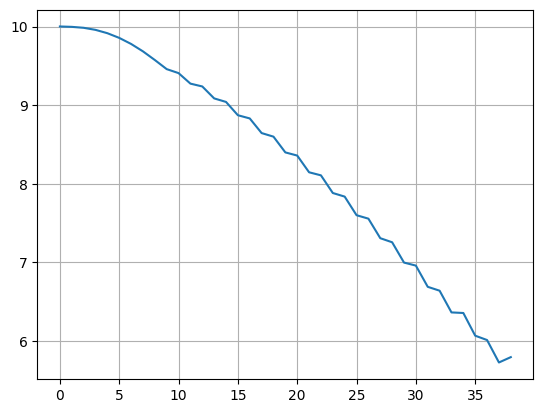

In [25]:
from matplotlib import pyplot as plt

er=er[1:]
plt.plot(er)
plt.grid()
plt.show()

## оцениваем результат

In [26]:
from sklearn.metrics.pairwise import pairwise_distances

In [27]:
D = pairwise_distances(Vi) # матрица расстояний
R = np.argsort(D) # номера слов в порядке увеличения расстояния

In [28]:
from numpy import random as rng

In [29]:
vocab_ = { v:k for k,v in vocab.items() } # нумеруем слов в словаре

nn = rng.permutation(len(vocab))[:20] # выбираем случайно N слов

# для выбранных слов печатаем близкие по w2v
{ vocab_[i] : [ vocab_[j] for j in  R[i,1:5]  ] for i in nn }

{'дюжины': ['добредешь', 'заднему', 'потянула', 'особнячок'],
 'полям': ['какую', 'зарабатываем', 'послушался', 'вдали'],
 'крови': ['коллега', 'защиты', 'незарегистрированный', 'понятно'],
 'всматриваясь': ['осторожно', 'бублик', 'уплатил', 'впечатление'],
 'воробей': ['станция', 'кислородом', 'эдаким', 'мистеру'],
 'начинала': ['веря', 'посматривает', 'лету', 'отправляйся'],
 'босса': ['лонг-айленде', 'выключил', 'изолгавшисьнакорню', 'проигрывал'],
 'жуликоватые': ['сквалыгу-старушку', 'фултон-стрит', 'передохнув', 'рекой'],
 'перепрыгивая': ['рубль', 'собеседника', 'исчезнувший', 'направление'],
 'заработает': ['умолкли', 'темно-красную', 'карнеги-холл', 'договариваться'],
 'успокоились': ['убежденные', 'триада', 'требуемая', 'прочесать'],
 'дорожными': ['простоты', 'возвращаюсь', 'разговаривать', 'кольнул'],
 'дураков': ['избаловать', 'порции', 'наткнулся', 'пожарной'],
 'получают': ['усаживают', 'стандартный', 'кого-нибудь', 'тормозных'],
 'протянувшейся': ['загнул', 'списком', '